In [1]:
# start me by CUDA_VISIBLE_DEVICES=1 jupyter notebook --port 8888
%matplotlib inline
import matplotlib.pyplot as plt

# Introduction Tensorpack

![img](https://github.com/ppwwyyxx/tensorpack/raw/master/.github/tensorpack.png)

## Advantages:

- based on pure TensorFlow (mix it with your-favourite-library (TM))
- supports **efficient** Multi-GPU
- intuitive dataflow and data handling in python
- **re-produces** state-of-the-art results (including model zoo)

```console
user@host pip install -U git+https://github.com/ppwwyyxx/tensorpack.git
```

ships some examples (reproducing the architecture + results):

- ResNet
- MaskRNN
- SuperResolution
- &lt; put your favourite GAN here &gt;

## Rant Against Keras (aka: Why you should never consider using Keras)

TensorFlow provides several features to speed up the training process and dataflow. Using all of them ensures you do not waste GPU time.

TensorFlow even includes a StageArea (compared to other frameworks like PyTorch).

Let's dive into some benchmarks:

### running Cifar10 (Keras - out-of-the-box)

```
cd git/github.com/tensorpack/benchmarks/other-wrappers/
CUDA_VISIBLE_DEVICES=1 python keras.cifar10.py
```

In [2]:
keras_per_sec = 50000/18.

print('iterations per second: %.2f' % keras_per_sec)

iterations per second: 2777.78


### running Cifar10 (TFlearn - out-of-the-box)

```
cd git/github.com/tensorpack/benchmarks/other-wrappers/
CUDA_VISIBLE_DEVICES=1 python tflearn.cifar10.py
```

In [ ]:
tl_per_sec = 50000/17.

print('iterations per second: %.2f' % tl_per_sec)

### running Cifar10 (Tensorpack - out-of-the-box)

```
cd git/github.com/tensorpack/benchmarks/other-wrappers/
CUDA_VISIBLE_DEVICES=1 python tensorpack.cifar10.py
```

In [ ]:
tp_per_sec = 50000/6.8

print('iterations per second:   %10.2f' % tp_per_sec)

print('speed-up factor (keras): %10.2f' % (tp_per_sec / keras_per_sec))
print('speed-up factor (tl):    %10.2f' % (tp_per_sec / tl_per_sec))

### Having a personal cluster at home? Train on 8 GPUs! Simultaneously!


|                      | 1 GPU   | 2 GPUs  | 8 GPUs    |
| -------------------- | ------- | ------  | --------- |
| tensorpack+ResNet50  | __318__ | __582__ | __2177__  |
| Keras+ResNet50       | 230     | 291     | 376       |
|                      |
| tensorpack+VGG16     | __226__ | __438__ | __1471__  |
| Keras+VGG16          | 188     | 320     | 501       |


see: https://github.com/tensorpack/benchmarks/tree/master/other-wrappers for code

In [3]:
import tensorflow as tf
import numpy as np
import time
from contextlib import contextmanager

@contextmanager
def benchmark(name="unnamed context"):
    elapsed = time.time()
    yield
    elapsed = time.time() - elapsed
    print('[{}] finished in {} ms'.format(name, int(elapsed * 1000)))

# Queues  (and Threading) for input data

In [4]:
def some_data():
    return np.random.randn(8, 28, 28, 1).astype(np.float32)

## naive (Keras-Style)

Using the `feed_dict` like presented last time seems to be an intuitive way, which is used by most people. However, this way the GPU needs to wait in each `sess.run` call for CPU to prepare data. This could be a potential bottleneck. The following example uses a very small "network".

While a larger neural network might hide the latency from `feed_dict` the pre-processing of handling of larger datasets usually make things even worse by having much higher latency. So the following is really __not__ an option

In [5]:
x = tf.placeholder(dtype=tf.float32, shape=[8, 28, 28, 1])
img = x
result_naive = tf.reduce_sum(img)

In [6]:
with tf.Session() as sess:
    with benchmark("naive"):
        for _ in range(200):
            sess.run(result_naive, feed_dict={x: some_data()})

[naive] finished in 199 ms


## improved: using Queues

In [7]:
x = tf.placeholder(dtype=tf.float32, shape=[8, 28, 28, 1])
queue = tf.FIFOQueue(200, [tf.float32], [[8, 28, 28, 1]])
result_improved = tf.reduce_sum(queue.dequeue())

In [8]:
with tf.Session() as sess:
    # can be done in parallel (in another thread)
    for _ in range(200):
        sess.run(queue.enqueue(x), {x: some_data()})
    
    with benchmark("improved"):
        for _ in range(200):
            sess.run(result_improved)
    

[improved] finished in 72 ms


## improved: using StagingArea(GPU)

In [9]:
from tensorflow.python.ops.data_flow_ops import StagingArea

x = tf.placeholder(dtype=tf.float32, shape=[8, 28, 28, 1])
stage = StagingArea([tf.float32], [[8, 28, 28, 1]], capacity=200)

result_improved2 = tf.reduce_sum(stage.get())

In [10]:
with tf.Session() as sess:
    # can be done in parallel
    for _ in range(200):
        sess.run(stage.put(x), {x: some_data()})
    
    with benchmark("improved++"):
        for _ in range(200):
            sess.run(result_improved2)


[improved++] finished in 56 ms


> Tensorpack uses both Queues + StagingArea (**out-of-the-box**)

| GPUS| with  Staging  | without Staging | speed-up |
| ----| ------- | ------- | ------------- |
|1 | 17.8s  |17.9s   |same |
|2 | 18.5s   | 19.6s   | 6%      |
|4 | 19.2s  | 21.6s   | 12%     |
|6 | 20.5s  | 22.9s   | 11.5%   |



- show MNIST and TensorBoard

# DataFlow

Default way in Python to generate data

In [11]:
def generate_image(height=256, width=384):
    return np.random.randn(256, 384, 3).astype(np.float32)

In [12]:
print generate_image().shape # Todo: which type?

(256, 384, 3)


In [13]:
# Question: which range (theoretically)?
for i in range(10):
    dp = generate_image()
    print i, dp.shape, dp.min(), dp.max()

0 (256, 384, 3) -4.5038476 4.3769073
1 (256, 384, 3) -4.3735223 4.6815505
2 (256, 384, 3) -4.448172 4.7492323
3 (256, 384, 3) -4.7744765 4.489028
4 (256, 384, 3) -4.4076414 4.0822587
5 (256, 384, 3) -4.922193 4.781825
6 (256, 384, 3) -4.5617332 4.680471
7 (256, 384, 3) -4.8442826 4.8508325
8 (256, 384, 3) -4.911341 4.605827
9 (256, 384, 3) -4.620947 4.792133


### Python Generator

In [14]:
def image_generator_loop(n=10, height=256, width=384):
    for _ in range(n):
        yield np.random.randn(256, 384, 3).astype(np.float32)

In [15]:
print image_generator_loop().shape # which type?

AttributeError: 'generator' object has no attribute 'shape'

In [16]:
for dp in image_generator_loop():
    print dp.shape, dp.min(), dp.max()

(256, 384, 3) -4.3248687 4.2775674
(256, 384, 3) -4.5469103 4.6611605
(256, 384, 3) -4.6130853 4.7931814
(256, 384, 3) -4.6091404 4.1724744
(256, 384, 3) -4.4752235 4.594284
(256, 384, 3) -4.6940713 4.5121746
(256, 384, 3) -4.5221395 4.763363
(256, 384, 3) -4.3550444 4.971853
(256, 384, 3) -4.795226 4.4119697
(256, 384, 3) -4.4059887 4.3745375


In [17]:
df = image_generator_loop()  # df: dataflow

for i, dp in enumerate(df):
    print i, dp.shape, dp.min(), dp.max()

0 (256, 384, 3) -4.239428 4.2976456
1 (256, 384, 3) -4.462009 4.7260528
2 (256, 384, 3) -4.627353 5.1484365
3 (256, 384, 3) -4.399835 4.600131
4 (256, 384, 3) -4.243345 4.38611
5 (256, 384, 3) -4.3831906 4.6453314
6 (256, 384, 3) -4.386298 5.065254
7 (256, 384, 3) -4.937729 4.6078386
8 (256, 384, 3) -4.2031083 4.749591
9 (256, 384, 3) -4.3930473 4.2064877


#### DataMapping: Normalize Data

Modifying Sequences in Python

In [18]:
def TransformData(seq, mapping):
    for dp in seq:
        yield mapping(dp)

In [19]:
def ScaleMapping(x):
    # x is assume a single image
    x -= x.min()
    x /= x.max()
    return x

In [20]:
df = image_generator_loop()
df = TransformData(df, ScaleMapping)

for i, dp in enumerate(df):
    print i, dp.shape, dp.min(), dp.max()

0 (256, 384, 3) 0.0 1.0
1 (256, 384, 3) 0.0 1.0
2 (256, 384, 3) 0.0 1.0
3 (256, 384, 3) 0.0 1.0
4 (256, 384, 3) 0.0 1.0
5 (256, 384, 3) 0.0 1.0
6 (256, 384, 3) 0.0 1.0
7 (256, 384, 3) 0.0 1.0
8 (256, 384, 3) 0.0 1.0
9 (256, 384, 3) 0.0 1.0


In [21]:
df = image_generator_loop()
df = TransformData(df, ScaleMapping)

In [22]:
print next(df)

[[[0.52609277 0.39125478 0.28864545]
  [0.49354303 0.52493614 0.33936802]
  [0.5052901  0.5136355  0.45974392]
  ...
  [0.5076445  0.3324983  0.39273325]
  [0.6048379  0.46139425 0.680654  ]
  [0.1842969  0.5288518  0.6325173 ]]

 [[0.49019623 0.59860075 0.39929488]
  [0.40937698 0.3956708  0.49038222]
  [0.45042002 0.19818854 0.5349833 ]
  ...
  [0.44720155 0.24185495 0.56526935]
  [0.66096616 0.3666565  0.76005566]
  [0.5055868  0.5065662  0.2886736 ]]

 [[0.34564012 0.6070584  0.45097256]
  [0.60262847 0.5355406  0.47860637]
  [0.7224314  0.3177805  0.7132999 ]
  ...
  [0.5769981  0.56263393 0.4009237 ]
  [0.31670928 0.48195398 0.47904137]
  [0.57017326 0.27828586 0.52649605]]

 ...

 [[0.39182982 0.5699699  0.2904339 ]
  [0.49156228 0.5853184  0.68426937]
  [0.2837426  0.4516338  0.43271512]
  ...
  [0.298493   0.47713387 0.5373619 ]
  [0.5024366  0.60953057 0.3204797 ]
  [0.524962   0.62968    0.79488754]]

 [[0.51655877 0.52358234 0.56990594]
  [0.47343144 0.39256838 0.58440644]


## Tensorpack: DataFlow
see: http://tensorpack.readthedocs.io/en/latest/modules/dataflow.html

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorpack as tp

In [24]:
df = tp.dataset.Mnist('train')
df.reset_state()

print next(df.get_data())

[array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.   

In [ ]:
# TODO: extract from df.get_data()

plt.imshow(img, cmap='gray');
plt.axis('off');
print('label is %i' % label)


In [ ]:
df = tp.dataset.Mnist('train')
# TODO: inspect dataflow here ...
df.reset_state()
d = next(df.get_data())

## Modifying data distribution 

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]


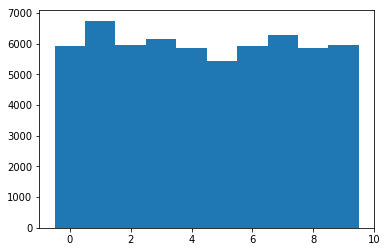

In [25]:
histogram = np.zeros((10, )) # k-th entry tells how many of these digits are observed
df = tp.dataset.Mnist('train')
df.reset_state()

for img, label in df.get_data():
    histogram[label] += 1
    
print(histogram)
plt.bar(range(10), histogram, 1);

Just consider "8" and "0"

In [ ]:
# dp is from a [img, label]- seq
def FilterMapping(dp):
    img, label = dp

    # TODO return if only if 8 or 0

In [ ]:
histogram = np.zeros((10, )) # k-th entry tells how many of these digits are observed

df = tp.dataset.Mnist('train')
df = tp.MapData(df, FilterMapping)
df.reset_state()

for img, label in df.get_data():
    histogram[label] += 1

print(histogram)
plt.bar(range(10), histogram, 1);

Wait we need to set the label to "0, 1"

In [ ]:
def CorrectLabels(dp):
    img, label = dp

    # set label of 8 to 1
    
    return [img, label]

In [ ]:
histogram = np.zeros((10, )) # k-th entry tells how many of these digits are observed

df = tp.dataset.Mnist('train')
df = tp.MapData(df, FilterMapping)
df = tp.MapData(df, CorrectLabels)
df.reset_state()

for img, label in df.get_data():
    histogram[label] += 1

print(histogram)
plt.bar(range(10), histogram, 1);

## Batching Data

In [26]:
df = tp.dataset.Mnist('train')
df = tp.PrintData(df)
df.reset_state()
d = next(df.get_data())

[0425 08:55:19 @common.py:771] DataFlow Info:
datapoint 0<1 with 2 components consists of
  0: ndarray:float32 of shape (28, 28) in range [0.0, 0.996078431606]
  1: uint8 with value 8


In [27]:
df = tp.dataset.Mnist('train')
df = tp.BatchData(df, 8)
df = tp.PrintData(df)
df.reset_state()
d = next(df.get_data())

[0425 08:55:21 @common.py:771] DataFlow Info:
datapoint 0<1 with 2 components consists of
  0: ndarray:float32 of shape (8, 28, 28) in range [0.0, 1.0]
  1: ndarray:uint8 of shape (8,) in range [0, 9]


## Prefetch Data (workaround GIL) 
###  -- Data Augmentation at its finest --

In [28]:
# question: why data augmentation
import numpy as np
df = tp.FakeData([[256, 256, 3], [1]], 8000, random=False, dtype=['float32', 'uint8'], domain=[(0, 255), (0, 10)])

# all data augmentation methos
augmentors = [
    tp.imgaug.RandomOrderAug([tp.imgaug.BrightnessScale((0.6, 1.4), clip=False),
                           tp.imgaug.Contrast((0.6, 1.4), clip=False),
                           tp.imgaug.Saturation(0.4, rgb=False),
                           tp.imgaug.Lighting(0.1,
                                           eigval=np.asarray([0.2175, 0.0188, 0.0045][::-1]) * 255.0,
                                           eigvec=np.array([[-0.5675, 0.7192, 0.4009],
                                                            [-0.5808, -0.0045, -0.8140],
                                                            [-0.5836, -0.6948, 0.4203]],
                                                           dtype='float32')[::-1, ::-1]
                                     )]),
    tp.imgaug.Flip(horiz=True)
]

df = tp.AugmentImageComponent(df, augmentors, copy=False)
df = tp.BatchData(df, 8)
df.reset_state()


tp.TestDataSpeed(df, size=1000).start()

100%|##########|1000/1000[00:32<00:00,31.04it/s]


In [31]:
df = tp.MultiProcessPrefetchData(df, nr_prefetch=100, nr_proc=4)

df.reset_state()

tp.TestDataSpeed(df, size=1000).start()

[0425 08:56:48 @parallel.py:178] [MultiProcessPrefetchData] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.


100%|##########|1000/1000[00:12<00:00,78.95it/s]


Have a look at `top`.

In [32]:
df = tp.dataset.Mnist('train')
df = tp.BatchData(df, 8)
df = tp.PrintData(df)
df.reset_state()
d = next(df.get_data())

[0425 08:57:05 @common.py:771] DataFlow Info:
datapoint 0<1 with 2 components consists of
  0: ndarray:float32 of shape (8, 28, 28) in range [0.0, 1.0]
  1: ndarray:uint8 of shape (8,) in range [0, 9]


Curse of Dimensionality